# TensorFlow2.0教程-使用keras训练模型

In [1]:
# !pip install -q pydo
# !apt-get install graphviz

In [2]:
# from __future__ import absolute_import, division, print_function
import tensorflow as tf
# tf.keras.backend.clear_session()
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [118]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1.一般的模型构造、训练、测试流程

In [50]:


# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)  # (b, 10)
model = keras.Model(inputs, outputs)
# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

x_val = x_train[-10000:]
y_val = y_train[-10000:]  # (b, )

x_train = x_train[:-10000]
y_train = y_train[:-10000]

# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3,
         validation_data=(x_val, y_val))
print('history:')
print(history.history)

result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)
pred = model.predict(x_test[:2])
print('predict:')
print(pred)



Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 2s 43us/sample - loss: 0.3408 - sparse_categorical_accuracy: 0.9042 - val_loss: 0.1948 - val_sparse_categorical_accuracy: 0.9426

In [4]:
model.evaluate?

## 2.自定义损失和指标
自定义指标只需继承Metric类， 并重写一下函数

\__init\__(self)，初始化。

update_state(self，y_true，y_pred，sample_weight = None)，它使用目标y_true和模型预测y_pred来更新状态变量。

result(self)，它使用状态变量来计算最终结果。

reset_states(self)，重新初始化度量的状态。


In [3]:
a = tf.Variable(2.1)
a.assign?

In [73]:
y_train.shape

(50000,)

In [51]:
def get_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    return model

In [116]:
# 这是一个简单的示例，显示如何实现CatgoricalTruePositives指标，该指标计算正确分类为属于给定类的样本数量

class CategoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CategoricalTruePostives, self).__init__(name=name, **kwargs)
        # 使用0 初始化 该指标
        self.true_postives = self.add_weight(name='tp', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)  # (b)
        # 对比2个一维array
        y_pred = tf.squeeze(y_pred)
        y_true = tf.squeeze(y_true)

        values = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
        
        values = tf.cast(values, tf.float32)  # 正确分类的样本数量
        
        if sample_weight is not None:  # 不同样本可以有不同权值
            sample_weight = tf.cast(sample_weight, tf.float32)
            values = tf.multiply(sample_weight, values)
        # num = tf.reduce_sum(y_true)
        # print(y_pred.shape, num)
        return self.true_postives.assign_add(tf.reduce_sum(values))  # 更新指标
    
    def result(self):
        return tf.identity(self.true_postives)  # Return a tensor with the same shape and contents as input
    
    def reset_states(self):
        # 指标清除
        # pass
        self.true_postives.assign(0.)  # Assigns a new value to this variable
        
model = get_model()
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CategoricalTruePostives()])

model.fit(x_train, y_train, batch_size=128, epochs=3)
#

Train on 50000 samples
Epoch 1/3
50000/50000 [==============================] - 1s 24us/sample - loss: 0.3903 - binary_true_postives: 44660.0000

In [111]:
m = CategoricalTruePostives()
labels1 = np.random.choice(10, 12).reshape((12, 1))
labels2 = np.random.random((12, 10))
m.update_state(labels1, labels2)


<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

In [119]:
# 以定义网络层的方式添加网络loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        # Add loss tensor(s), potentially dependent on layer inputs.
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
keras.utils.plot_model(model,  show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 4s 87us/sample - loss: 2.3492 - sparse_categorical_accuracy: 0.1130

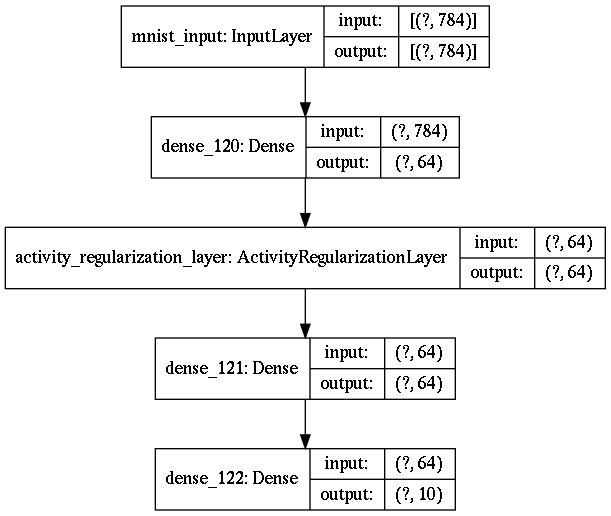

In [120]:
keras.utils.plot_model(model,  show_shapes=True)

In [121]:
# 也可以以定义网络层的方式添加要统计的metric
# 在训练结果中会显示这个metric项目
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        """
	    Sample-wise metric reduction function.
	    If aggregation=None, it indicates that the metric tensor provided has been aggregated already.
	     eg, bin_acc = BinaryAccuracy(name='acc') followed by model.add_metric(bin_acc(y_true, y_pred)).
	     If aggregation='mean', the given metric tensor will be sample-wise reduced using mean function.
	     eg, model.add_metric(tf.reduce_sum(outputs), name='output_mean',aggregation='mean').
        """
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)
keras.utils.plot_model(model, show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 5s 95us/sample - loss: 0.3058 - sparse_categorical_accuracy: 0.9108 - std_of_activation: 1.0256

In [122]:
# 也可以直接在model上面加
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)

model.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
model.add_loss(tf.reduce_sum(h1)*0.1)

# keras.utils.plot_model(model, 'net001.png', show_shapes=True)

model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(x_train, y_train, batch_size=32, epochs=1)

Train on 50000 samples
50000/50000 [==============================] - 5s 92us/sample - loss: 2.3610 - sparse_categorical_accuracy: 0.1137 - std_of_activation: 0.3083

处理使用validation_data传入测试数据，还可以使用validation_split划分验证数据

ps:validation_split只能在用numpy数据训练的情况下使用

In [123]:


model.fit(x_train, y_train, batch_size=32, epochs=1, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
40000/40000 [==============================] - 4s 100us/sample - loss: 2.3013 - sparse_categorical_accuracy: 0.1141 - std_of_activation: 0.3087 - val_loss: 2.3013 - val_sparse_categorical_accuracy: 0.1115 - val_std_of_activation: 0.3063

## 3.使用tf.data构造数据

In [124]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model
model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
model.fit(train_dataset, epochs=3, steps_per_epoch=100,
         validation_data=val_dataset, validation_steps=3)



Train for 100 steps, validate for 3 steps
Epoch 1/3
100/100 [==============================] - 1s 7ms/step - loss: 0.7884 - sparse_categorical_accuracy: 0.7903 - val_loss: 0.3840 - val_sparse_categorical_accuracy: 0.9010
Epoch 2/3
100/100 [==============================] - 0s 3ms/step - loss: 0.3570 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.3480 - val_sparse_categorical_accuracy: 0.9010

## 4.样本权重和类权重
“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类“0”比数据中的类“1”少两倍，则可以使用class_weight = {0：1.，1：0.5}。

In [125]:
# 增加第5类的权重
import numpy as np
# 类权重
model = get_compiled_model()
class_weight = {i:1.0 for i in range(10)}
class_weight[5] = 2.0
print(class_weight)
model.fit(x_train, y_train,
         class_weight=class_weight,
         batch_size=64,
         epochs=4)
# 样本权重
model = get_compiled_model()
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0
model.fit(x_train, y_train,
         sample_weight=sample_weight,
         batch_size=64,
         epochs=4)


{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 2.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0}
  ...
    to  
  ['...']
Train on 50000 samples
Epoch 1/4
50000/50000 [==============================] - 2s 50us/sample - loss: 0.3635 - sparse_categorical_accuracy: 0.9040

In [14]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=3, )

Train for 782 steps
Epoch 1/3
782/782 [==============================] - 3s 3ms/step - loss: 0.3622 - sparse_categorical_accuracy: 0.9031

## 5.多输入多输出模型

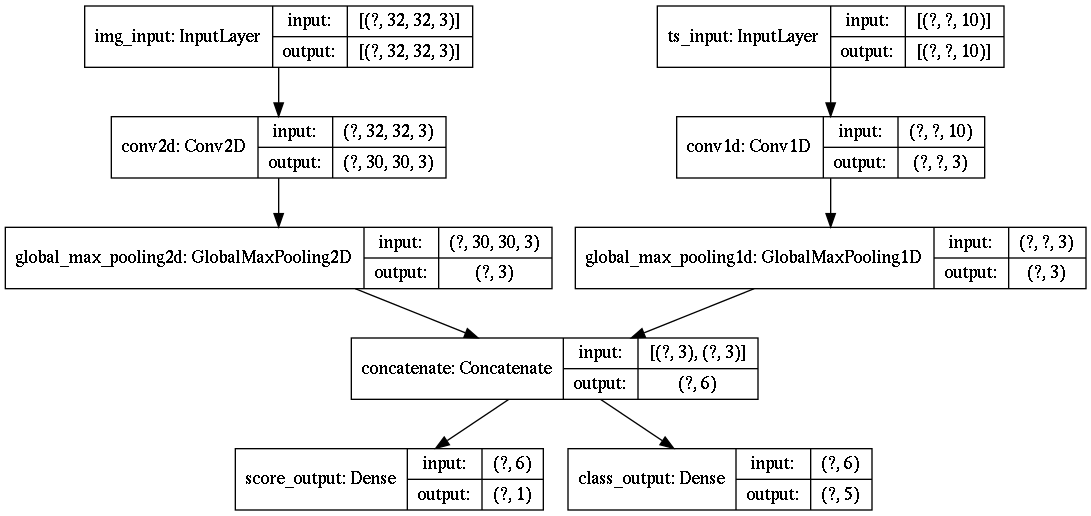

In [126]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])
keras.utils.plot_model(model, 'multi_input_output_model.png'
                       , show_shapes=True)

In [128]:
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    # 以list方式指定
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])

# 还可以指定loss的权重
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    # 以dict方式指定
    loss={'score_output': keras.losses.MeanSquaredError(),
          'class_output': keras.losses.CategoricalCrossentropy()},
    metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
                              keras.metrics.MeanAbsoluteError()],
             'class_output': [keras.metrics.CategoricalAccuracy()]},
    loss_weights={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的loss置0
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={'class_output': keras.losses.CategoricalCrossentropy()})

## 6.使用回调
Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

- 在培训期间的不同时间点进行验证（超出内置的每个时期验证）
- 定期检查模型或超过某个精度阈值
- 在训练似乎平稳时改变模型的学习率
- 在训练似乎平稳时对顶层进行微调
- 在培训结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

**可使用的内置回调有**

- ModelCheckpoint：定期保存模型。
- EarlyStopping：当训练不再改进验证指标时停止培训。
- TensorBoard：定期编写可在TensorBoard中显示的模型日志（更多细节见“可视化”）。
- CSVLogger：将丢失和指标数据流式传输到CSV文件。
- 等等

### 6.1回调使用

In [ ]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor='val_loss',
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1)
]
model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

In [ ]:
# checkpoint模型回调
model = get_compiled_model()
check_callback = keras.callbacks.ModelCheckpoint(
    filepath='mymodel_{epoch}.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)



In [ ]:
# 动态调整学习率
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [ ]:
# 使用tensorboard
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='./full_path_to_your_logs')
model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)


### 6.2创建自己的回调方法


In [ ]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:',self.losses[-1])
        
model = get_compiled_model()

callbacks = [
    LossHistory()
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

## 7.自己构造训练和验证循环

In [ ]:
# Get the model.
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 自己构造循环
for epoch in range(3):
    print('epoch: ', epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        # 开一个gradient tape, 计算梯度
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            
            loss_value = loss_fn(y_batch_train, logits)
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))
            

In [ ]:
# 训练并验证
# Get model
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# Prepare the training dataset.
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# Iterate over epochs.
for epoch in range(3):
  print('Start of epoch %d' % (epoch,))
  
  # Iterate over the batches of the dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
      
    # Update training metric.
    train_acc_metric(y_batch_train, logits)

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))

  # Display metrics at the end of each epoch.
  train_acc = train_acc_metric.result()
  print('Training acc over epoch: %s' % (float(train_acc),))
  # Reset training metrics at the end of each epoch
  train_acc_metric.reset_states()

  # Run a validation loop at the end of each epoch.
  for x_batch_val, y_batch_val in val_dataset:
    val_logits = model(x_batch_val)
    # Update val metrics
    val_acc_metric(y_batch_val, val_logits)
  val_acc = val_acc_metric.result()
  val_acc_metric.reset_states()
  print('Validation acc: %s' % (float(val_acc),))

In [ ]:
##　添加自己构造的loss, 每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):
  
  def call(self, inputs):
    self.add_loss(1e-2 * tf.reduce_sum(inputs))
    return inputs
  
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)


In [ ]:
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
  print('Start of epoch %d' % (epoch,))

  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      logits = model(x_batch_train)
      loss_value = loss_fn(y_batch_train, logits)

      # Add extra losses created during this forward pass:
      loss_value += sum(model.losses)
      
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Log every 200 batches.
    if step % 200 == 0:
        print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
        print('Seen so far: %s samples' % ((step + 1) * 64))